## Example: Visualizing Seattle Bicycle Counts

As a more involved example of working with some time series data, let's take a look at bicycle counts on Seattle's [Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965).
This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.
The hourly bicycle counts can be downloaded from http://data.seattle.gov/; here is the [direct link to the dataset](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k).

As of summer 2016, the CSV can be downloaded as follows:

In [11]:
#필요한 라이브러리 import
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [5]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4496k    0 4496k    0     0   962k      0 --:--:--  0:00:04 --:--:-- 1030k


Once this dataset is downloaded, we can use Pandas to read the CSV output into a ``DataFrame``.
We will specify that we want the Date as an index, and we want these dates to be automatically parsed:

In [6]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True) #data 불러오기
data.head()


,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


For convenience, we'll further process this dataset by shortening the column names and adding a "Total" column:

In [7]:
data.columns = ['Total', 'East', 'West'] #열이름 지정


Now let's take a look at the summary statistics for this data:

In [8]:
data.dropna().describe() #결측치제거후 describe로 요약출력

,Total,East,West
count,144352.000000,144352.000000,144352.000000
mean,111.188013,50.529241,60.658772
std,141.260941,65.050403,87.812023
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,75.000000
max,1097.000000,698.000000,850.000000


### Visualizing the data

We can gain some insight into the dataset by visualizing it.
Let's start by plotting the raw data:

In [9]:
%matplotlib inline
import seaborn; seaborn.set()

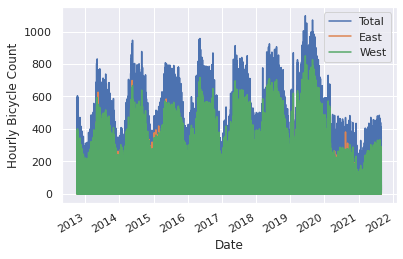

In [12]:
data.plot() #plot
plt.ylabel('Hourly Bicycle Count');

The ~150K hourly samples are far too dense for us to make much sense of.
We can gain more insight by resampling the data to a coarser grid.
Let's resample by week:

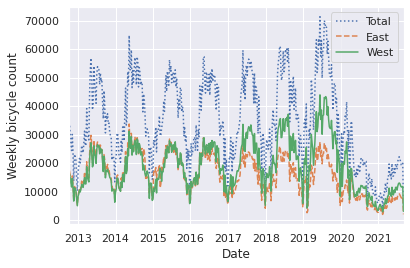

In [13]:
weekly = data.resample('W').sum() #주간(W)을 기준으로 구간별 리샘플 후 모두 더한값을 weekly로 저장
weekly.plot(style=[':', '--', '-']) #plot
plt.ylabel('Weekly bicycle count');

This shows us some interesting seasonal trends: as you might expect, people bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week (likely dependent on weather;).

Another way that comes in handy for aggregating the data is to use a rolling mean, utilizing the ``pd.rolling_mean()`` function.
Here we'll do a 30 day rolling mean of our data, making sure to center the window:

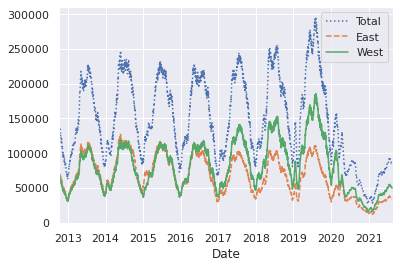

In [14]:
daily = data.resample('D').sum() # 마찬가지로 일(D)를 기준으로 구간별 리샘플 후 더함
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-']) #30일(한달) 기준 sum값의 이동 평균 plot

The jaggedness of the result is due to the hard cutoff of the window.
We can get a smoother version of a rolling mean using a window function–for example, a Gaussian window.
The following code specifies both the width of the window (we chose 30 days) and the width of the Gaussian within the window (we chose 10 days):

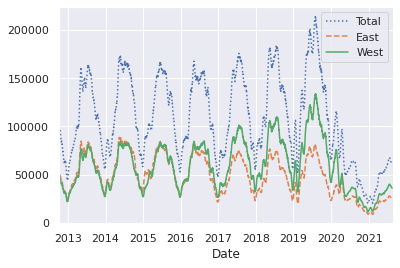

In [15]:
daily.rolling(30, center=True, # 30일(한달) 기준으로 window 계산 준비
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']); #이동평균의 연산은 gaussian 활용. 표준편차의 합계를 plot

### Digging into the data

While these smoothed data views are useful to get an idea of the general trend in the data, they hide much of the interesting structure.
For example, we might want to look at the average traffic as a function of the time of day.
We can do this using the GroupBy functionality discussed in Aggregation and Grouping section:

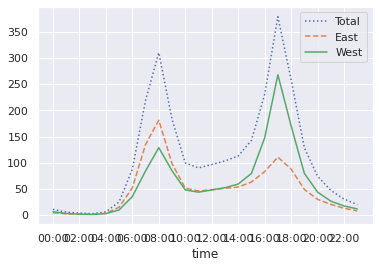

In [16]:
by_time = data.groupby(data.index.time).mean() #시간 기준으로 groupby. 묶은 후 평균값 
hourly_ticks = 2 * 60 * 60 * np.arange(12) # 2시간 단위로 x축 나눔
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']); #plot

The hourly traffic is a strongly bimodal distribution, with peaks around 8:00 in the morning and 5:00 in the evening.
This is likely evidence of a strong component of commuter traffic crossing the bridge.
This is further evidenced by the differences between the western sidewalk (generally used going toward downtown Seattle), which peaks more strongly in the morning, and the eastern sidewalk (generally used going away from downtown Seattle), which peaks more strongly in the evening.

We also might be curious about how things change based on the day of the week. Again, we can do this with a simple groupby:

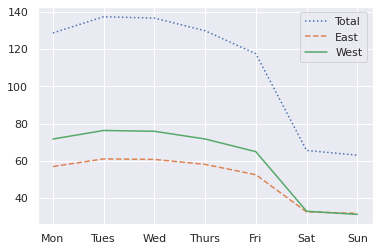

In [17]:
by_weekday = data.groupby(data.index.dayofweek).mean() #dayofweek -> 해당날짜에 요일에 따라 월요일:0 화요일:1 ... 토요일:5 일요일:6으로 반환. 각 요일의 값들을 묶어서 평균값을 내기 
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'] # index는 각 요일
by_weekday.plot(style=[':', '--', '-']); #plot

This shows a strong distinction between weekday and weekend totals, with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound GroupBy and look at the hourly trend on weekdays versus weekends.
We'll start by grouping by both a flag marking the weekend, and the time of day:

In [18]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend') #0,1,2,3,4 즉 월화수목금. 주말을 제외한 요일. 주간의 데이터만 사용
by_time = data.groupby([weekend, data.index.time]).mean() #주간 데이터의 요일별로 시간별 평균값을 사용

Now we'll use some of the Matplotlib tools to plot two panels side by side:

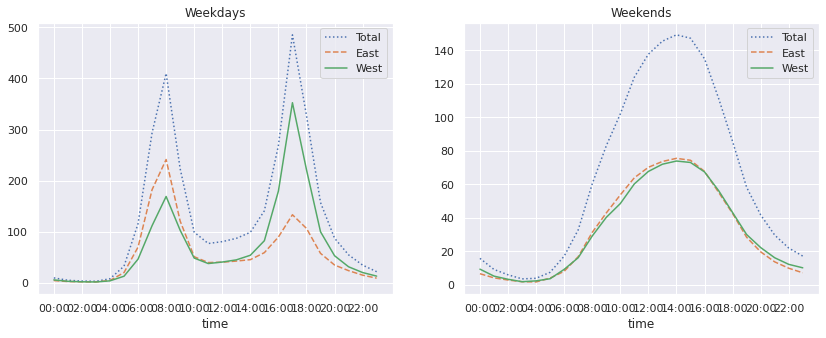

In [19]:
import matplotlib.pyplot as plt #plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

The result is very interesting: we see a bimodal commute pattern during the work week, and a unimodal recreational pattern during the weekends.
It would be interesting to dig through this data in more detail, and examine the effect of weather, temperature, time of year, and other factors on people's commuting patterns; for further discussion, see my blog post ["Is Seattle Really Seeing an Uptick In Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), which uses a subset of this data.